# Chapter 1 - Markov Chain Monte Carlo

In [1]:
%matplotlib inline

In [2]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform, multivariate_normal

## 1.1 Generating $U$ ~ $Uniform(0, 1)$

In [3]:
U = [random.random() for i in xrange(10000)]

## 1.2 Inverse CDF Method

Inverse CDF for $Exp(\lambda)$ is:

$ F^{-1}(p;\lambda) = \frac{-ln(1-p)}{\lambda} $

In [4]:
qexp = lambda p, l: -1.*math.log(1.-p)/l

In [5]:
X = [qexp(u, 0.5) for u in U]

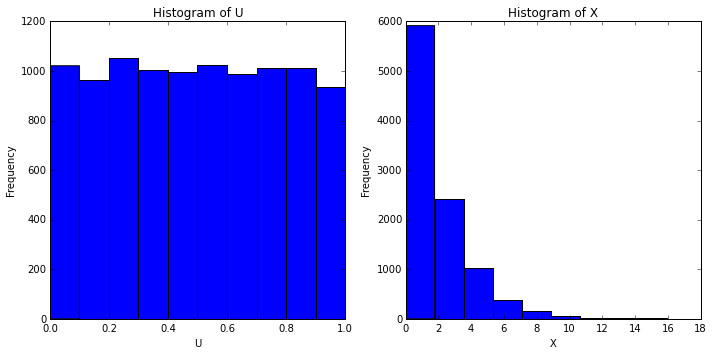

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(U)
plt.title('Histogram of U')
plt.xlabel('U')
plt.ylabel('Frequency')


plt.subplot(122)
plt.hist(X)
plt.title('Histogram of X')
plt.xlabel('X')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.3 Accept/Reject Algorithm

Want to sample randomly from a distribution over (say) $X = (0., 1.)$. $f(x)$ is bounded by some ``M`` maximum.

* Generate $x_i$ ~ $Unif(0, 1)$ 
* Generate $y_i = u_iM$ where $u_i$ ~ $Unif(0, 1)$
* Reject points above $f(x)$ (density curve). Accept dots below.
    * if $y_i <= f(x_i)$ then accept $x_i$.
    * if $u_i <= \frac{f(x_i)}{M}$ then accept
    * else reject

Pros:
* Simple

Cons
* Have to find the maximum (hard)
* Inefficient (low acceptance rate)

Alternative (better):
* Bound the distribution more closely
* Still inefficient, still need maximum

### 1.3.1 MCMC algorithm

Markov-Chain Monte Carlo:
* Monto Carlo: random accept/reject aspect.
* Develop a chain of values, $x_0, x_1, ... x_i$
    * To generate next step $x_{i+1}$, only consider $x_i$.
    * Markov property is that I only consider the current state.

Suppose we have some distribution, and a starting value from that distribution $x_0$. To generate $x_1$:
* Given $x_i$, propose some nearby value: $x_{i+1}^* = x_i + noise$.
* If $f(x_{i+1}^* > f(x_i)$, then accept $x_{i+1} = x_{i+1}^*$. (generalized by...)
* If $f(x_{i+1}^* <= f(x_i)$, then sometimes accept...
    * Accept if: $u_{i+1}^* < \frac{f(x_{i+1}^*)}{f(x_i)}$, where $u_{i+1}^*$ ~ $Unif(0, 1)$

In [7]:
df = lambda x: 0.7*norm.pdf(x, loc=2, scale=1) + 0.3*norm.pdf(x, loc=5, scale=1)    # Some PDF.

In [8]:
density_data = zip(*[(x, df(x)) for x in np.arange(-3, 12, 15./200)])

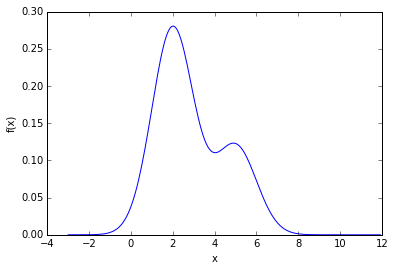

In [9]:
plt.plot(*density_data)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()

Generate a random proposal value within (say) +/- 2.

In [10]:
rproposal = lambda x_i: x_i + np.random.uniform(-2., 2.)

In [11]:
x = [3]      # Arbitrary starting point.
x_star = [3]
x_star.append(rproposal(x[0]))    # Propose the next value.

if (df(x_star[1]) / df(x[0])) > np.random.uniform(): 
    x.append(x_star[1])    # Accept.
else:
    x.append(x[0])    # Reject.

In [12]:
x

[3, 3]

In [13]:
def eval(x_prev, x_prop):
    if (df(x_prop) / df(x_prev)) > np.random.uniform(): 
        return x_prop
    return x_prev

In [14]:
x, x_star = [3], [3]
for i in xrange(10):
    x_star.append(rproposal(x[-1]))
    x.append(eval(x[-1], x_star[-1]))

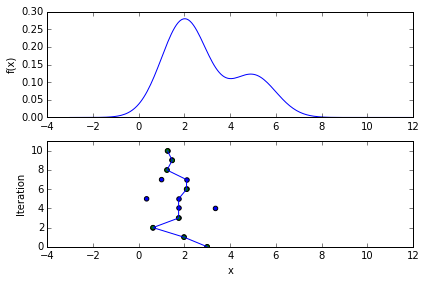

In [15]:
plt.subplot(211)
plt.plot(*density_data)
plt.xlim(-4, 12)

plt.ylabel('f(x)')

plt.subplot(212)
plt.plot(x, range(len(x)))
plt.scatter(x, range(len(x)))
rejected = lambda x_a, x_p: 'green' if x_a == x_p else 'blue'
plt.scatter(x_star, range(len(x)), c=[rejected(x[i], x_star[i]) for i in range(len(x))])
plt.xlim(-4, 12)

plt.ylim(0, len(x))
plt.xlabel('x')
plt.ylabel('Iteration')
plt.tight_layout()
plt.show()

If the proposal is generated in a non-uniform fashion, then the accept/reject rule must change. 

Accept iff: $u_{i+1} <= \frac{f(x_{i+1}^*)}{f(x_i)}\frac{g(x_i| x_{i+1}^*)}{g(x_{i+1}^*| x_i)}$

$g(x_{i+1}^*|x_i)$ is the density of the proposal distribution, centered at $x_i$.

In [16]:
g_unif = lambda x_u, y_u: uniform.pdf(x_u)*uniform.pdf(y_u)/uniform.pdf(x_u)
g_norm = lambda x_u, y_u: norm.pdf(x_u)*norm.pdf(y_u)/norm.pdf(x_u)

In [17]:
def MCMC(df, start, rprop, dprop=None, N=1000):
    """
    Perform Markov-Chain Monte Carlo simulation.
    
    Parameters
    ----------
    df : callable
        Target distribution.
    start : float
        Starting value.
    rprop : callable
        Proposal function.
    dprop : callable (proposed, current)
        (default: None) Gives the density of the proposal function
        centered on the current value.
    N : int
        Number of iterations
        
    Returns
    -------
    chain : list
        Markov chain of size N.
    """
    if dprop is None:   # Treat as symmetric.
        dprop = lambda to, fr: 1.
        
    chain = [start]
    for i in xrange(N):
        x_star = rprop(chain[-1])
        r1 = df(x_star) / df(chain[-1])
        r2 = dprop(chain[-1], x_star) / dprop(x_star, chain[-1])
        if r1*r2 > np.random.uniform():
            chain.append(x_star)
        else:
            chain.append(chain[-1])
    return chain

In [18]:
def trace_plot(chain):
    plt.plot(chain)
    plt.ylabel('Value')
    plt.xlabel('Iteration')
    plt.show()

In [19]:
chain = MCMC(df, 2, rproposal, N=1000)

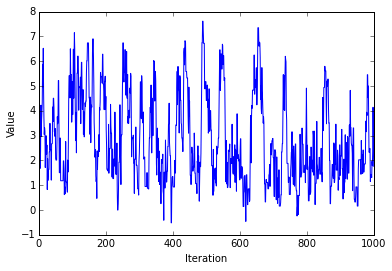

In [20]:
trace_plot(chain)

In [21]:
chain += MCMC(df, chain[-1], rproposal, N=10000)

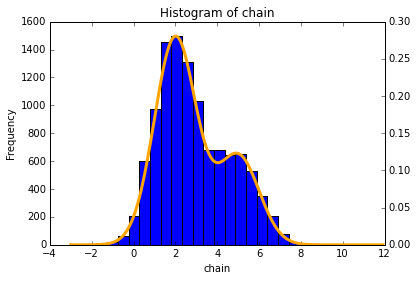

In [22]:
plt.hist(chain, bins=20)
plt.title('Histogram of chain')
plt.xlabel('chain')
plt.ylabel('Frequency')
ax = plt.gca()

# Plot the target density function.
ax2 = ax.twinx()
ax2.plot(*density_data, c='orange', lw=3)
plt.show()

Pros (compared to bounded scatter method):
* More efficient.
* No need to find maximum value.

Cons:
* Still need to decide on a good proposal distribution.
* Need a starting value.

#### With asymmetric proposal distribution

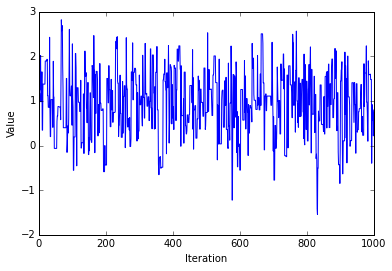

In [23]:
chain = MCMC(df, 2, rproposal, g_norm, N=1000)
trace_plot(chain)

### 1.3.2 Common problems

In [24]:
p_small = lambda x: x + np.random.uniform(-0.1, 0.1)
chain = MCMC(df, 2, p_small, N=1000)

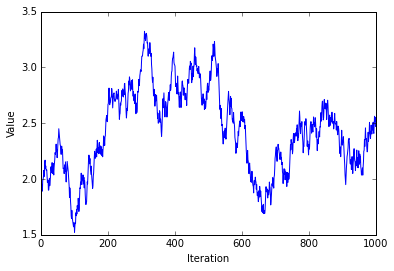

In [25]:
trace_plot(chain)

In [26]:
p_large = lambda x: x + np.random.uniform(-30., +30.)
chain = MCMC(df, 2, p_large, N=1000)

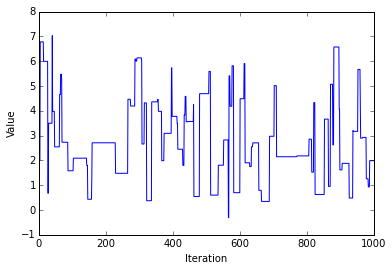

In [27]:
trace_plot(chain)

#### Burn-in

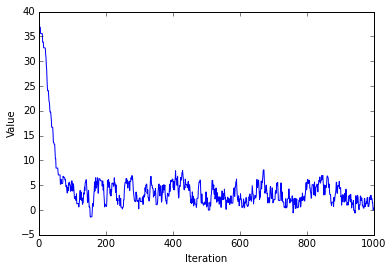

In [28]:
chain = MCMC(df, 40, rproposal, N=1000)
trace_plot(chain)

In [29]:
def trace_plots(chains):
    for chain in chains:
        plt.plot(chain)
    plt.ylabel('Value')
    plt.xlabel('Iteration')
    plt.show()

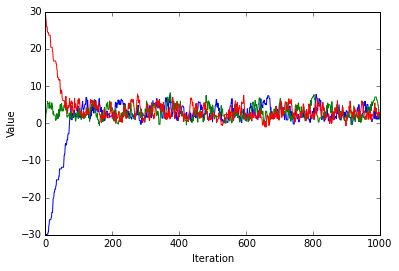

In [30]:
chain1 = MCMC(df, -30., rproposal, N=1000)
chain2 = MCMC(df, 0., rproposal, N=1000)
chain3 = MCMC(df, 30., rproposal, N=1000)
trace_plots([chain1, chain2, chain3])

## Assessing Convergence

Visually, it is clear that chains converge around iteration 100. But we would really like a metric for convergence, mixing.

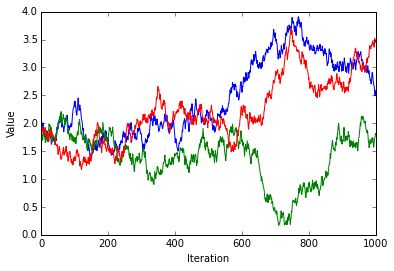

In [31]:
p_small = lambda x: x + np.random.uniform(-0.1, 0.1)
chain1 = MCMC(df, 2, p_small, N=1000)
chain2 = MCMC(df, 2, p_small, N=1000)
chain3 = MCMC(df, 2, p_small, N=1000)
trace_plots([chain1, chain2, chain3])

Should have ~ same means, and ~ same variance. Use an ANOVA.

Let $\bar{x_i}$ be the mean of chain $i$, and $s_i^2$ be the variance of chain $i$.  At convergence, $\bar{x_1} = \bar{x_2} = \bar{x_3}... = \mu$ and $s_1^2 = s_2^2 = s_3^2... = \sigma^2$.

#### Two ways to approximate $\sigma^2$

1. $W = \frac{1}{m}\sum^m_{i=1}{s^2_i}$, $m=$no. of chains.
2. at convergence, $\bar{x_i}$ ~ $N(\mu, \frac{\sigma^2}{n})$, $n=$no. of chain steps. "Central limit theorem"
    * Implies: $n\bar{x_i}$ ~ $N(\mu, \sigma^2)$
    
So the variance($n\bar{x_i}$) values estimates $\sigma^2$

$B = \frac{n}{m-1}\sum{(\bar{x_i} - \bar{x..})}^2$

$\bar{x..}$ is the mean of all values

If the chains haven't converged, then $B >> \sigma^2$, and $W < \sigma^2$ (within-chain variance is too small).

define $\hat{\sigma}^2 = \frac{n-1}{n}W + \frac{1}{n}B$

$\hat{R} = \sqrt{\frac{\hat{\sigma}^2}{W}}$ -- scale reduction factor. $\hat{R} > 1$. 

This gives an idea of how much more variance could increase if we let chains continue to wander in the space. If space is not well-explored, $\hat{R}$ is really big. As $\hat{R}$ approaches 1, we have better explored the space (and chains are agreeing).

$1 <= \hat{R} < 1.05$ is considered "close enough." But trust the trace-plots over $\hat{R}$.

Big idea: Do chains have the same mean (ANOVA)? 

$\hat{R}$ is the Gelman + Rubin (1992) statistic.

In [35]:
def Gelman(chains):
    if len(chains.shape) == 3:
        N_p = chains.shape[2]
    else:
        N_p = 1
    generate = lambda ptn: np.array([np.array([np.array([ptn(p, i, c) 
                                                         for p in xrange(N_p)
                                               for i in xrange(chains.shape[1])])
                                     for c in xrange(chains.shape[0])])])
    params = generate(lambda p, i, c: 'x{0}'.format(p))
    iters = generate(lambda p, i, c: i)
    labels = generate(lambda p, i, c: c)
                      
    data = zip(chains.flat, params.flat, iters.flat, labels.flat)
    dataframe = pd.DataFrame(data, columns=('Value', 'Parameter', 'Iteration', 'Chain'))

    xbar = dataframe.groupby('Parameter').Value.mean()
    m = chains.shape[0]
    xbar_i = dataframe.groupby(('Parameter', 'Chain')).Value.mean()
    s2_i = dataframe.groupby(('Parameter', 'Chain')).Value.var()
    n = dataframe.groupby(('Parameter', 'Chain')).Value.count().mean()

    W = s2_i.mean()
    B = (n/(m-1.)) * ((xbar_i - xbar)**2).sum()
    sigma2_hat = W*(n-1.)/n + B/n
    R_hat = np.sqrt(sigma2_hat/W)
    n_eff = m*n*sigma2_hat/B    # I missed what this was for.
                      
    return R_hat, n_eff

In [36]:
p_small = lambda x: x + np.random.uniform(-.1, .1)
chain1 = np.array(MCMC(df, 3, p_small, N=1000))
chain2 = np.array(MCMC(df, 4, p_small, N=1000))
chain3 = np.array(MCMC(df, 5, p_small, N=1000))
chain4 = np.array(MCMC(df, 2, p_small, N=1000))

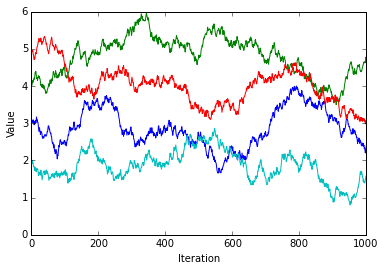

(2.7808642052267509, 4.5933891464345997)

In [37]:
trace_plots([chain1, chain2, chain3, chain4])
Gelman(np.array([chain1, chain2, chain3, chain4]))

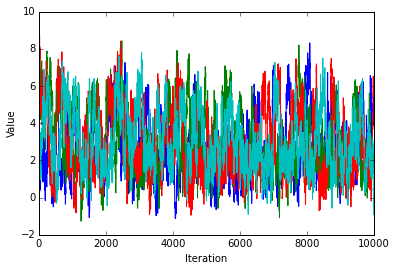

(1.0074327973921309, 270.27021967987031)

In [38]:
p_small = lambda x: x + np.random.uniform(-.6, .6)
chain1 = MCMC(df, 3, p_small, N=10000)
chain2 = MCMC(df, 4, p_small, N=10000)
chain3 = MCMC(df, 5, p_small, N=10000)
chain4 = MCMC(df, 2, p_small, N=10000)
trace_plots([chain1, chain2, chain3, chain4])
Gelman(np.array([chain1, chain2, chain3, chain4]))

### Multiple MCMC chains, with support for multi-variate distributions

mMCMC -- takes a list of starting points and runs all chains

In [39]:
def mMCMC(df, start, rprop, dprop=None, N=1000, num_chains=4):
    """
    Perform Markov-Chain Monte Carlo simulation with multiple chains..
    
    Parameters
    ----------
    df : callable
        Target distribution.
    start : float
        Starting value.
    rprop : callable
        Proposal function.
    dprop : callable (proposed, current)
        (default: None) Gives the density of the proposal function
        centered on the current value.
    N : int
        Number of iterations
    num_chains : int
        Number of chains.
        
    Returns
    -------
    chains : numpy.array
        Shape (``num_chains``, ``N``, num. parameters)
    """

    if dprop is None:   # Treat as symmetric.
        dprop = lambda to, fr: 1.
    
    if not hasattr(start, '__iter__'):
        start = np.array([np.array(start) for i in xrange(num_chains)])
    
    chains = []
    for j in xrange(num_chains):
        chain = [start[j]]
        for i in xrange(N):
            x_star = rprop(chain[-1])
            r1 = df(x_star) / df(chain[-1])
            r2 = dprop(chain[-1], x_star) / dprop(x_star, chain[-1])
            if r1*r2 > np.random.uniform():
                chain.append(x_star)
            else:
                chain.append(chain[-1])
        chains.append(np.array(chain))
    return np.array(chains)

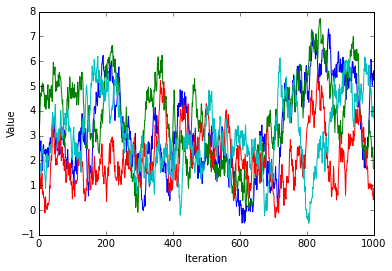

(1.0870723049871038, 25.868926977387702)

In [40]:
chains = mMCMC(df, [3,4,1,2], p_small, N=1000, num_chains=4)
trace_plots(chains)
Gelman(chains)

#### Multi-variate example

In [41]:
dtarget = lambda x: multivariate_normal.pdf(x, mean=(3, 10), cov=[[3, 3], [3, 7]])

In [42]:
rprop = lambda x: multivariate_normal.rvs(mean=x)

In [49]:
chains = mMCMC(dtarget, [[0, 0]], rprop, N=50, num_chains=1)

In [50]:
x1 = np.linspace(-6, 12, 101)
x2 = np.linspace(-11, 31, 101)
X, Y = np.meshgrid(x1, x2)
Z = np.array(map(dtarget, zip(X.flat, Y.flat))).reshape(101, 101)

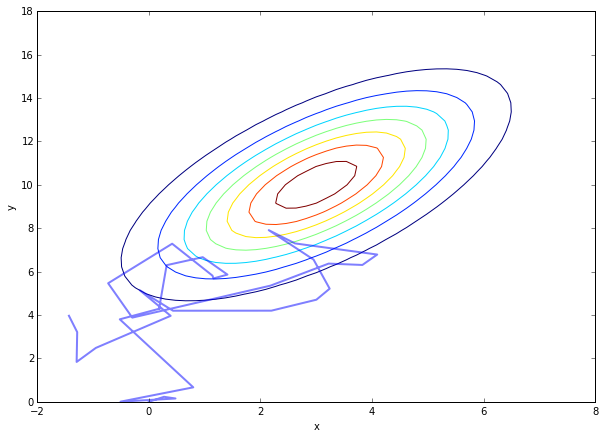

In [51]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.plot(chains[0][:, 0], chains[0][:, 1], lw=2, alpha=0.5)
plt.xlim(-2, 8)
plt.ylim(0, 18)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [46]:
chains = mMCMC(dtarget, [[0, 0], [8, 18]], rprop, N=1000, num_chains=2)

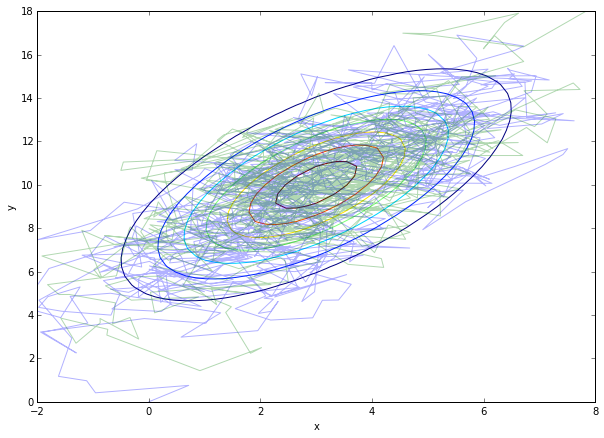

In [48]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.plot(chains[0][:, 0], chains[0][:, 1], alpha=0.3)
plt.plot(chains[1][:, 0], chains[1][:, 1], alpha=0.3)
plt.xlim(-2, 8)
plt.ylim(0, 18)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
Gelman(chains)